# 01_ENSO_models
### Take the preprocessed anomaly data and regresses out ENSO indices

This notebook imports the preprocess gridded sea surface temperature anomalies (SSTA) data from [00_preprocess.ipynb](00_preprocess.ipynb) and remove signals of El Nino-Southern Oscillatoin variability. 

![preprocess_flow](images/01_ENSO_models.png)


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import s3fs


#### Import data
- load the monthly preprocessed OISSTv2.1 anomalies


In [ ]:
# file_path = '/burg/abernathey/users/hillary/oisst_v21/preprocessed_OISSTv21.nc'
# ds = xr.open_dataset(file_path)
# ds

#### Import data
- load the OISSTv2.1 data

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()

In [3]:
da = ds.sst.isel(zlev=0)
da.load();

#### Transform time into decimal year and add it as a new coordinate --> `da.dyr`

In [4]:
years = pd.DatetimeIndex(da.time.values).year
months = pd.DatetimeIndex(da.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

#### Define [Nino SST Indices](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) as SST  averaged across the respected region defined below with a 5-month running mean:
- Niño 3 (5N-5S, 150W-90W)
- Niño 3.4 (5N-5S, 170W-120W)
- Niño 4 (5N-5S, 160E-150W)


![nino-regions](images/nino-regions.gif)

In [ ]:
# df = pd.read_csv('/burg/home/hs3277/marine-heatwaves/data/nino34.csv', header=None)
# df = df.where(df>-99.99, other=np.nan)
# dn = df.to_numpy()

# nino34 = []
# dyr = []
# for i in range(0, dn.shape[0]):
#     nino34.extend(dn[i,1:])
#     dyr.extend(([int(dn[i][0])] * 12) + (np.arange(1,13)-0.5)/12)
# nino34 = np.array(nino34)
# dyr = np.array(dyr)


In [ ]:
# dlon = np.cos(ds.lat * np.pi/180) *111e3
# dlat = 111e3 * xr.ones_like(ds.lon)
# cell_area = dlon * dlat

# Nino3 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(210, 270)).weighted(cell_area).mean(('lat','lon')).rolling(time=5, center=True).mean()
# Nino3_4 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(190, 240)).weighted(cell_area).mean(('lat','lon')).rolling(time=5, center=True).mean()
# Nino4 = ds.ssta_notrend.sel(lat=slice(-5, 5), lon=slice(200, 210)).weighted(cell_area).mean(('lat','lon')).rolling(time=5, center=True).mean()

In [5]:
dlon = np.cos(da.lat * np.pi/180) *111e3
dlat = 111e3 * xr.ones_like(da.lon)
cell_area = dlon * dlat

Nino3 = da.sel(lat=slice(-5, 5), lon=slice(210, 270)).weighted(cell_area).mean(('lat','lon'))#.rolling(time=5, center=True).mean()
Nino3_4 = da.sel(lat=slice(-5, 5), lon=slice(190, 240)).weighted(cell_area).mean(('lat','lon'))#.rolling(time=5, center=True).mean()
Nino4 = da.sel(lat=slice(-5, 5), lon=slice(200, 210)).weighted(cell_area).mean(('lat','lon'))#.rolling(time=5, center=True).mean()

In [ ]:
# X = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)] + [Nino3])
# Y = da#[:,550,900]
# X_mat=X.T 
# beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y)
# yhat = X_mat.dot(beta_hat)


In [14]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)] + [Nino4])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':da.time.values, 'coeff':np.arange(1,8,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,8,1), 'time':da.time.values})  

# resulting coefficients of the model
sst_mod = pmodel_da.dot(da) #xr.DataArray(pmodel_da.dot(da), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':da.lat.values, 'lon':da.lon.values})  


In [15]:
sst_reconstruct = model_da.dot(sst_mod)
ssta = da - sst_reconstruct


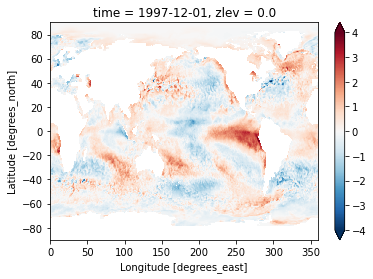

In [16]:
ssta.sel(time=('1997-12-01')).plot(vmin=-4, vmax=4, cmap='RdBu_r', extend='both')

In [17]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(

        Nino4=(['time'], Nino4.data),
        ssta_notrend_noNino4=(['time', 'lat', 'lon'], ssta.data),
     
    ),
    coords=dict(
        time=(['time'], da.time.data),
        lat=(['lat'], da.lat.data),
        lon=(['lon'], da.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged OISST v2.1 data"),
)


ds_new.to_netcdf(path+'ssta_notrend_noNino4.nc', mode='w')

#### Decompose SST fields into mean, trend, annual and semi-annual harmonics, Nino3, Nino3.4, and Nino4


In [ ]:
# indices = np.array([Nino3, Nino3_4, Nino4])
# indices_label = ('ssta_nino3', 'ssta_nino3_4', 'ssta_nino4')
# da = []

# for i in enumerate(indices):
#     model = i[1][np.newaxis,:]
#     pmodel = np.linalg.pinv(model)
#     model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':ds.time.values, 'coeff':[indices_label[i[0]]]}) 
#     pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':[indices_label[i[0]]], 'time':ds.time.values})  
#     Nino_mod = pmodel_da.dot(ds.ssta_notrend)
#     model_ssta = model_da[:,0].dot(Nino_mod[0,:,:])
#     da.append(model_ssta)

# ssta_Nino = xr.concat(da, dim='coeff')


In [ ]:
plt.figure(figsize=(10,6))
ssta_Nino.weighted(cell_area).mean(('lat','lon')).plot(hue='coeff');


### Remove Nino anomaies from SSTA 

In [ ]:
# SST anomalies with ENSO signal removed
indices_label = ['ssta_no_nino3', 'ssta_no_nino3_4', 'ssta_no_nino4']
da = []
for i in enumerate(ssta_Nino.coeff.values):
    da.append(ds.ssta_notrend-ssta_Nino.isel(coeff=i[0]))
    
ssta_notrend_noNino = xr.concat(da, dim='coeff').assign_coords(coeff=indices_label)


In [ ]:
plt.figure(figsize=(10,6))
ds.ssta_notrend.weighted(cell_area).mean(('lat','lon')).plot(color='k', lw=2, label='ssta no trend')
ssta_notrend_noNino.weighted(cell_area).mean(('lat','lon')).plot(hue='coeff');


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ds.ssta_notrend.sel(time=('1997-12-01')).plot(ax=ax1)
ssta_notrend_noNino.sel(coeff='ssta_no_nino3', time=('1997-12-01')).plot(ax=ax2);


#### Save as a netCDF

In [ ]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(

        Nino3=(['time'], Nino3.data),
        Nino3_4=(['time'], Nino3_4.data),
        Nino4=(['time'], Nino4.data),
        
        ssta_Nino3=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino3').data),
        ssta_Nino3_4=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino3_4').data),
        ssta_Nino4=(['time', 'lat', 'lon'], ssta_Nino.sel(coeff='ssta_nino4').data),
        
        ssta_notrend_noNino3=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino3').data),
        ssta_notrend_noNino3_4=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino3_4').data),
        ssta_notrend_noNino4=(['time', 'lat', 'lon'], ssta_notrend_noNino.sel(coeff='ssta_no_nino4').data),        
    ),
    coords=dict(
        time=(['time'], ds.time.data),
        lat=(['lat'], ds.lat.data),
        lon=(['lon'], ds.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged and detrended OISST v2.1 data"),
)


ds_new.to_netcdf(path+'ENSO_models_OISSTv21.nc', mode='w')
